In [1]:
import mysql.connector

In [2]:
import pandas as pd

In [7]:
import io

In [8]:
from io import StringIO

In [33]:
import pandas as pd
import re
import os.path
import csv
import logging
import sys


def convert_dump_to_intermediate_csv(dump_filename, csv_header, csv_out_put_file, delete_csv_file_after_read=True):
    """
    :param dump_filename: five an mysql export dump (mysqldump...syntax)
    :param csv_header: the very first line in the csv file which should appear, give a string separated by coma
    :param csv_out_put_file: the name of the csv file
    :param delete_csv_file_after_read: if you set this to False, no new records will be written as the file exists.
    :return: returns a pandas dataframe for further analysis.
    """
    with open(dump_filename, 'r') as f:
        for line in f:
            pre_compiled_all_values_per_line = re.compile('(?:INSERT\sINTO\s\S[a-z\S]+\sVALUES\s+)(?P<values>.*)(?=\;)')
            result = pre_compiled_all_values_per_line.finditer(line)
            for element in result:
                values_only = element.groups('values')[0]
                value_compile = re.compile('\(.*?\)')
                all_identified = value_compile.finditer(values_only)
                for single_values in all_identified:
                    string_to_split = single_values.group(0)[1:-1]
                    string_array = string_to_split.split(",")

                    if not os.path.exists(csv_out_put_file):
                        with open(csv_out_put_file, 'w', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow(csv_header.split(","))
                            writer.writerow(string_array)
                    else:
                        with open(csv_out_put_file, 'a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow(string_array)
    df = pd.read_csv(csv_out_put_file)
    if delete_csv_file_after_read:
        os.remove(csv_out_put_file)
    return df


In [34]:
if __name__ == "__main__":
    log_name = 'test.log'
    LOGGER = logging.getLogger(log_name)
    LOGGER.setLevel(logging.DEBUG)
    LOGGER.addHandler(logging.NullHandler())
    FORMATTER = logging.Formatter(
        fmt='%(asctime)s %(levelname)-8s %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')
    SCREEN_HANDLER = logging.StreamHandler(stream=sys.stdout)
    SCREEN_HANDLER.setFormatter(FORMATTER)
    LOGGER.addHandler(SCREEN_HANDLER)

In [40]:
dump_filename = './ks-data.sql'
header_of_csv_file = "id,name,sub_category_id,contry_id,currency_id,launched,deadline,goal,pledged,backers,outcome" # i did not identify the columns in the table definition...
csv_output_file = 'campaign2.csv'

## Read Data

In [300]:
data=pd.read_csv('./campaign2.csv',on_bad_lines='skip')

In [301]:
data.head()

,id,name,sub_category_id,contry_id,currency_id,launched,deadline,goal,pledged,backers,outcome
0,1,'Ragdolls',23,2,2,'2013-04-25 00:00:00','2013-05-25 00:00:00',15000.00,20.00,3,'failed'
1,2,'One To Ten',47,1,1,'2015-11-16 00:00:00','2015-12-16 00:00:00',223.68,413.81,23,'successful'
2,3,'Future Gun - A short film about kids and adva...,24,2,2,'2013-08-28 00:00:00','2013-09-27 00:00:00',5000.00,1497.00,28,'failed'
3,4,'Fourth Wave Apparel—Vintage Fashion for the M...,52,2,2,'2014-07-22 00:00:00','2014-08-21 00:00:00',6000.00,8795.00,218,'successful'
4,5,'The Rich Lifestyle',9,2,2,'2016-08-24 00:00:00','2016-09-28 00:00:00',2000000.00,2.00,2,'failed'


In [302]:
data=data.dropna(axis=0,how='any')

In [303]:
data=pd.DataFrame(data)
data.head()

,id,name,sub_category_id,contry_id,currency_id,launched,deadline,goal,pledged,backers,outcome
0,1,'Ragdolls',23,2,2,'2013-04-25 00:00:00','2013-05-25 00:00:00',15000.00,20.00,3,'failed'
1,2,'One To Ten',47,1,1,'2015-11-16 00:00:00','2015-12-16 00:00:00',223.68,413.81,23,'successful'
2,3,'Future Gun - A short film about kids and adva...,24,2,2,'2013-08-28 00:00:00','2013-09-27 00:00:00',5000.00,1497.00,28,'failed'
3,4,'Fourth Wave Apparel—Vintage Fashion for the M...,52,2,2,'2014-07-22 00:00:00','2014-08-21 00:00:00',6000.00,8795.00,218,'successful'
4,5,'The Rich Lifestyle',9,2,2,'2016-08-24 00:00:00','2016-09-28 00:00:00',2000000.00,2.00,2,'failed'


## Part 1 - Conduct a Preliminary Data Analysis

In [304]:
from scipy import stats

In [305]:
data.columns

Index(['id', 'name', 'sub_category_id', 'contry_id', 'currency_id', 'launched',
       'deadline', 'goal', 'pledged', 'backers', 'outcome'],
      dtype='object')

In [313]:
data['outcome']=data['outcome'].astype('category')
data['name']=data['name'].astype('category')
data[['sub_category_id', 'contry_id', 'currency_id']]=data[['sub_category_id', 'contry_id', 'currency_id']].astype('int32')

In [314]:
data['backers']=pd.to_numeric(data['backers'])

In [315]:
data.dtypes

id                   object
name               category
sub_category_id       int32
contry_id             int32
currency_id           int32
launched             object
deadline             object
goal                float64
pledged             float64
backers               int64
outcome            category
dtype: object

In [318]:
out=data.groupby(['outcome']).agg({'backers':'count'})

In [319]:
res = out.apply(lambda x: x.sort_values(ascending=False).head(3))
res

,backers
outcome,
'failed',7134
'successful',4808
'canceled',522


In [127]:
res = out.apply(lambda x: x.sort_values(ascending=True).head(3))
res

,backers
outcome,
'suspended',24
'live',96
'undefined',130


In [153]:
sub=data.groupby(['sub_category_id']).agg({'backers':'count'})

In [154]:
res = sub.apply(lambda x: x.sort_values(ascending=False).head(3))
res

,backers
sub_category_id,
8,802
9,587
3,552


In [150]:
money=data.groupby(['outcome']).agg({'goal':'sum'})
res = money.apply(lambda x: x.sort_values(ascending=False).head(3))
res

,goal
outcome,
'failed',7.275420e+08
'canceled',1.067596e+08
'successful',4.646728e+07


In [131]:
money=data.groupby(['sub_category_id']).agg({'goal':'sum'})
res = money.apply(lambda x: x.sort_values(ascending=False).head(3))
res

,goal
sub_category_id,
58,1.205218e+08
4,1.189281e+08
9,1.176007e+08


In [168]:
company=data.groupby(['outcome','name']).agg({'goal':'sum','backers':'count'})
g = company['goal'].groupby('outcome', group_keys=False)

In [169]:
g.nlargest(1)

outcome       name                                                          
'canceled'    '404 ERROR - The first emergency kit for an internet blackout'    8.876757e+07
'failed'      'Is Anyone Out There ?'                                           1.000000e+08
'live'        'Kitty\'s Secret Activities Memoir'                               1.000000e+06
'successful'  'WISH I WAS HERE'                                                 2.000000e+06
'suspended'   'New Micro Drone 3.5 - First Person View Flying!'                 2.117792e+05
'undefined'   'Who are you? – Feel the Great Shift of Awakening'                9.900000e+03
Name: goal, dtype: float64

In [172]:
country=data.groupby(['contry_id']).agg({'pledged':'sum'})

In [175]:
res = country.apply(lambda x: x.sort_values(ascending=False).head(3))
res

,pledged
contry_id,
2,94238515.80
1,8775814.37
3,1872495.17


In [177]:
country=data.groupby(['contry_id']).agg({'backers':'count'})
res = country.apply(lambda x: x.sort_values(ascending=False).head(3))
res

,backers
contry_id,
2,9891
1,1109
3,491


In [185]:
data['time_length']=(pd.to_datetime(data['deadline'])-pd.to_datetime(data['launched'])).astype('timedelta64[h]')

In [256]:
c=data.groupby(['outcome']).agg({'time_length':'sum','goal':'sum'})
c

,time_length,goal
outcome,,
'canceled',437112.0,1.067596e+08
'failed',6007368.0,7.275420e+08
'live',93912.0,3.981773e+06
'successful',3742536.0,4.646728e+07
'suspended',18048.0,4.892113e+05
'undefined',106680.0,5.476021e+05


In [237]:
b=data.groupby(['outcome']).agg({'time_length':'sum','backers':'count'})
b

,time_length,backers
outcome,,
'canceled',437112.0,522
'failed',6007368.0,7134
'live',93912.0,96
'successful',3742536.0,4808
'suspended',18048.0,24
'undefined',106680.0,130


## Part 2 - Visualize the Data

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

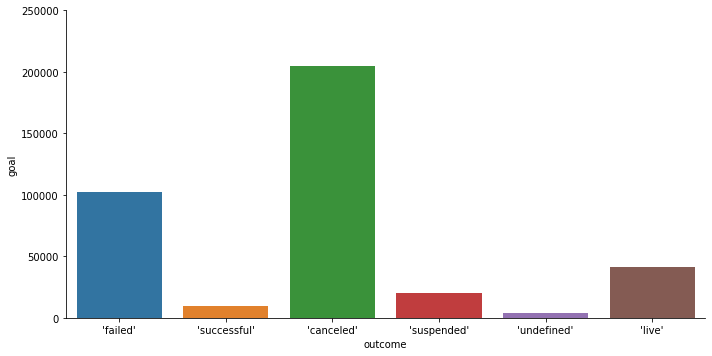

In [219]:
g=sns.catplot(x="outcome", y="goal",
                data=data,ci=None,
                kind="bar",  aspect=2)

g.set(ylim=(0,250000))

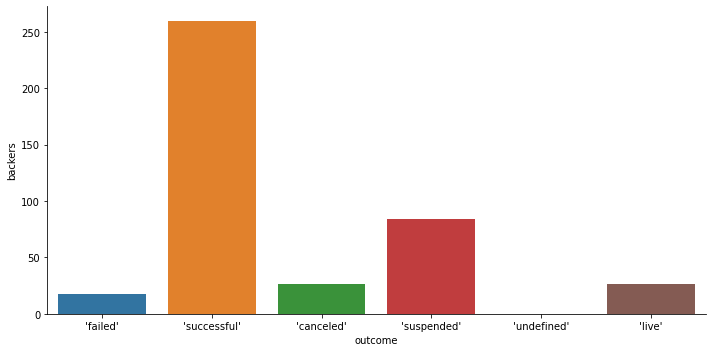

In [227]:
sns.catplot(x="outcome", y="backers",
                data=data, ci=None,
                kind="bar",  aspect=2)

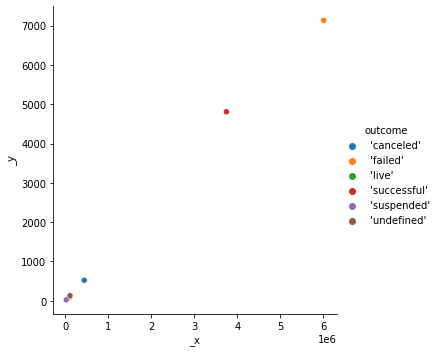

In [253]:
sns.relplot(data=b, x=b['time_length'].values, y=b['backers'].values, hue=b.index)

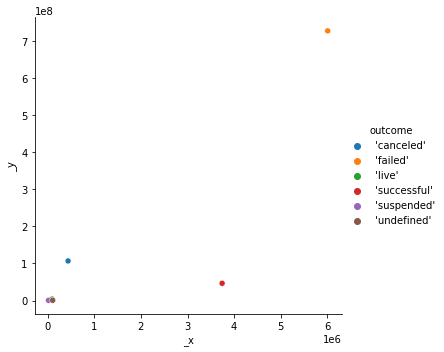

In [259]:
sns.relplot(data=c, x=c['time_length'].values, y=c['goal'].values, hue=c.index)
g.set(ylim=(0,2500000))

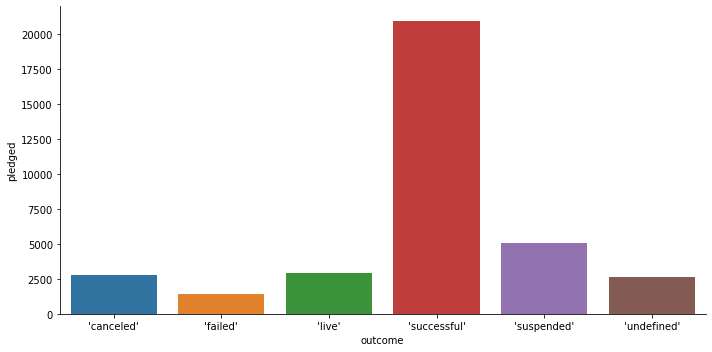

In [320]:
sns.catplot(x="outcome", y="pledged",
                data=data, ci=None,
                kind="bar",  aspect=2)